# Autoregressive Model Testing (SARIMA & SARIMAX)

In [94]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.api import OLS, add_constant
from scipy.stats import shapiro, anderson
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from scipy import stats 
from statsmodels.stats.stattools import durbin_watson
from itertools import product
from itertools import product
from tqdm import tqdm 
from joblib import Parallel, delayed

## Data Preparation

In [95]:
# Load data
df = pd.read_excel('data/trimmed_Monthly Mastersheet Original Data.xlsx')
# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

In [96]:
df_exog = pd.read_excel('data/All Exogenous Variables.xlsx')
# Ensure date is datetime and set index
df_exog['Month'] = pd.to_datetime(df_exog['Month'])
df_exog.set_index('Month', inplace=True)
df_exog.index = pd.date_range(start=df_exog.index[0], periods=len(df_exog), freq='MS')
df_exog.columns = df_exog.columns.str.strip()

In [97]:
print(df_exog.columns.to_list())

['Bitcoin_lag0', 'Bitcoin_lag1', 'Bitcoin_lag2', 'Bitcoin_lag3', 'Bitcoin_lag4', 'Bitcoin_lag5', 'Bitcoin_lag6', 'Litecoin_lag0', 'Litecoin_lag1', 'Litecoin_lag2', 'Litecoin_lag3', 'Litecoin_lag4', 'Litecoin_lag5', 'Litecoin_lag6', 'XRP_lag0', 'XRP_lag1', 'XRP_lag2', 'XRP_lag3', 'XRP_lag4', 'XRP_lag5', 'XRP_lag6', 'Ethereum_lag0', 'Ethereum_lag1', 'Ethereum_lag2', 'Ethereum_lag3', 'Ethereum_lag4', 'Ethereum_lag5', 'Ethereum_lag6', 'Dogecoin_lag0', 'Dogecoin_lag1', 'Dogecoin_lag2', 'Dogecoin_lag3', 'Dogecoin_lag4', 'Dogecoin_lag5', 'Dogecoin_lag6', 'Cardano_lag0', 'Cardano_lag1', 'Cardano_lag2', 'Cardano_lag3', 'Cardano_lag4', 'Cardano_lag5', 'Cardano_lag6', 'Tether_lag0', 'Tether_lag1', 'Tether_lag2', 'Tether_lag3', 'Tether_lag4', 'Tether_lag5', 'Tether_lag6', 'USD Coin_lag0', 'USD Coin_lag1', 'USD Coin_lag2', 'USD Coin_lag3', 'USD Coin_lag4', 'USD Coin_lag5', 'USD Coin_lag6']


In [104]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin']
nonstable_list = ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano']
all_exog = df_exog.columns.to_list()
stable_list = ['Tether', 'USD Coin']
train_start = '2017-09-01'
train_end = '2024-01-01'

In [105]:
ar_orders = {} 
ar_orders['LFPR'] = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 0, 'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 3, 'XRP_lag': 0, 'Ethereum_lag': 1, 'Dogecoin_lag': 5, 'Cardano_lag': 0, 'USD Coin_lag': 0} 
ar_orders['CPI'] = {'p': 1, 'd': 2, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'Bitcoin_lag': 0, 'Tether_lag': 1, 'Litecoin_lag': 1, 'XRP_lag': 0, 'Ethereum_lag': 1, 'Dogecoin_lag': 1, 'Cardano_lag': 1, 'USD Coin_lag': 0} 
ar_orders['r'] = {'p': 1, 'd': 2, 'q': 0, 'P': 0, 'D': 1, 'Q': 0, 'Bitcoin_lag': 1, 'Tether_lag': 1, 'Litecoin_lag': 1, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 2, 'Cardano_lag': 2, 'USD Coin_lag': 0} 
ar_orders['M1'] = {'p': 1, 'd': 3, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 1, 'XRP_lag': 3, 'Ethereum_lag': 0, 'Dogecoin_lag': 6, 'USD Coin_lag': 1} 
ar_orders['GDP'] = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 2, 'Bitcoin_lag': 0, 'Tether_lag': 1, 'Litecoin_lag': 1, 'Ethereum_lag': 6} 
ar_orders['IM'] = {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 2, 'Tether_lag': 2, 'Cardano_lag': 2, 'USD Coin_lag': 2} 
ar_orders['EX'] = {'p': 1, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 'Tether_lag': 3, 'Cardano_lag': 0, 'Ethereum_lag': 1} 
ar_orders['CC'] = {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'Tether_lag': 4, 'XRP_lag': 0, 'Cardano_lag': 0, 'USD Coin_lag': 0}
# ar_orders['PC1_macro'] = {'p': 1, 'd': 3, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 
#                           'Bitcoin_lag': 2, 'Tether_lag': 0, 'Litecoin_lag': 2, 'XRP_lag': 4, 'Ethereum_lag': 1, 'Dogecoin_lag': 4, 
#                           'Cardano_lag': 1, 'USD Coin_lag': 4, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 1, 'VIX_lag': 0}
# ar_orders['PC2_macro'] = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 2, 
#                           'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 1, 
#                           'Cardano_lag': 1, 'USD Coin_lag': 2, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 0, 'VIX_lag': 0}
# ar_orders['CC % Change'] = {'p': 2, 'd': 0,'q': 0, 'P': 2, 'D': 1, 'Q': 0}
# ar_orders['VIX'] = {'p': 1, 'd': 0,'q': 0, 'P': 1, 'D': 1, 'Q': 0}
# ar_orders['MOVE'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 0, 'Q': 0}
# ar_orders['vol_LFPR'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_CPI'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_r'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_M1'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_GDP'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_IM'] = {'p': 1, 'd': 2,'q': 0}
# ar_orders['vol_EX'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_CC'] = {'p': 1, 'd': 1,'q': 0}

### Checking Model Assumption

In [ ]:
def check_model_assumptions(y_train, X_train, model_residuals):
    # Add constant to X
    X_const = add_constant(X_train)
    
    # 1. Breusch–Pagan test for heteroskedasticity
    ols_model = OLS(y_train, X_const).fit()
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(ols_model.resid, X_const)

    # 2. Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = shapiro(model_residuals)

    # 3. Anderson-Darling test
    ad_result = anderson(model_residuals)
    ad_stat = ad_result.statistic
    ad_crit = list(zip(ad_result.significance_level, ad_result.critical_values))

    # 6. Mean of residuals
    mean_resid = model_residuals.mean()

    # 7. Durbin-Watson test for autocorrelation
    dw_stat = durbin_watson(model_residuals)

    
    return {
        "Breusch-Pagan p": bp_pvalue,
        "Shapiro p": shapiro_p,
        "Anderson stat": ad_stat,
        "Anderson crit": ad_crit,
        "Mean resid": mean_resid,
        "Durbin-Watson": durbin_watson(model_residuals),
    }

## Testing Significance of All Lag for All Crypto

In [108]:
def run_model_all_exog(df, df_exog, macro, plot=False):
    outliers = ['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
                '2020-07-01', '2020-08-01', '2020-09-01']

    # Get ARIMA orders
    order_dict = ar_orders.get(macro, {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0})
    p, d, q = order_dict['p'], order_dict['d'], order_dict['q']
    P, D, Q = order_dict['P'], order_dict['D'], order_dict['Q']

    ### ==== AR Data: Use only macro series ==== ###
    df_macro = df[[macro]].dropna().copy()
    df_macro = df_macro[~df_macro.index.isin(pd.to_datetime(outliers))]
    target_ar = df_macro[macro]
    train_endog_ar = target_ar[train_start:train_end]
    test_endog_ar = target_ar[train_end:]

    ### ==== ARX Data: Use macro + all exog vars with lag 0 ==== ###
    # df_exog_clean = df_exog.dropna().copy()
    df_exog_clean = df_exog.iloc[:, :26].dropna().copy()

    df_exog_clean = df_exog_clean[~df_exog_clean.index.isin(pd.to_datetime(outliers))]


    # Align df_exog with df_macro
    df_joint = df_macro.join(df_exog_clean, how='inner')
    df_joint = df_joint.dropna()

    target_arx = df_joint[macro]
    exog = df_joint.drop(columns=[macro])

    train_endog_arx = target_arx[train_start:train_end]
    train_exog = exog[train_start:train_end]
    test_endog_arx = target_arx[train_end:]
    test_exog = exog[train_end:]

    ### ==== Fit AR and ARX Models ==== ###
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        ar_model = SARIMAX(train_endog_ar, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        ar_result = ar_model.fit(disp=False)
        arx_model = SARIMAX(train_endog_arx, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        arx_result = arx_model.fit(disp=False)
        print(arx_result.summary())
        pvals = arx_result.pvalues
        with pd.option_context('display.float_format', lambda x: f"{x:.7e}"):
             print(pvals)
        for warning in w:
            if issubclass(warning.category, ConvergenceWarning):
                print(f"[WARNING] Convergence issue in macro: {macro}")

    ### ==== Forecasts ==== ###
    pred_ar = ar_result.get_forecast(steps=len(test_endog_ar)).predicted_mean
    conf_int_ar = ar_result.get_forecast(steps=len(test_endog_ar)).conf_int()

    pred_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).predicted_mean
    conf_int_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).conf_int()

    # Align indices
    pred_ar.index = test_endog_ar.index
    pred_arx.index = test_endog_arx.index
    conf_int_ar.index = test_endog_ar.index
    conf_int_arx.index = test_endog_arx.index

    # Residuals
    arx_residuals = arx_result.resid[14:]

    ### ==== Plotting ==== ###
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_endog_ar, label='Training Actual', color='black')
        plt.plot(ar_result.fittedvalues, label='AR Fitted', linestyle='--', color='blue')
        plt.plot(arx_result.fittedvalues, label='ARX Fitted', linestyle='--', color='red')
        plt.title(f"In-Sample Fitted Values: {macro}")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(target_ar[train_start:], label='Actual ' + macro, color='black')
        plt.plot(pred_ar, label='AR Forecast', linestyle='--', color='blue')
        plt.fill_between(pred_ar.index, conf_int_ar.iloc[:, 0], conf_int_ar.iloc[:, 1], color='blue', alpha=0.1)
        plt.plot(pred_arx, label='ARX Forecast', linestyle='--', color='red')
        plt.fill_between(pred_arx.index, conf_int_arx.iloc[:, 0], conf_int_arx.iloc[:, 1], color='red', alpha=0.1)
        plt.title("Out-of-Sample Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(test_endog_ar, label='Actual', marker='o', color='black')
        plt.plot(pred_ar, label='AR Forecast', linestyle='--', marker='x', color='blue')
        plt.plot(pred_arx, label='ARX Forecast', linestyle='--', marker='s', color='red')
        plt.title("Forecast vs Actual (Test Period)")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

    ### ==== Metrics ==== ###
    metrics = [
        {
            'Model': 'AR',
            'MAE': mean_absolute_error(test_endog_ar, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog_ar, pred_ar)),
            'R2': r2_score(test_endog_ar, pred_ar),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_ar, pred_ar) * 100,
            'Order': f'({p},{d},{q})'
        },
        {
            'Model': 'ARX',
            'MAE': mean_absolute_error(test_endog_arx, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog_arx, pred_arx)),
            'R2': r2_score(test_endog_arx, pred_arx),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_arx, pred_arx) * 100,
            'Order': f'({p},{d},{q})'
        }
    ]

    assumptions = check_model_assumptions(train_endog_arx[14:], train_exog[14:], arx_residuals)
    return pd.DataFrame(metrics).set_index('Model'), assumptions


                                        SARIMAX Results                                        
Dep. Variable:                                     GDP   No. Observations:                   40
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -113.170
Date:                                 Thu, 03 Jul 2025   AIC                            286.341
Time:                                         10:46:49   BIC                            325.216
Sample:                                     10-01-2020   HQIC                           297.900
                                          - 01-01-2024                                         
Covariance Type:                                   opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Bitcoin_lag0     90.1930    120.735      0.747      0.455    -146.44

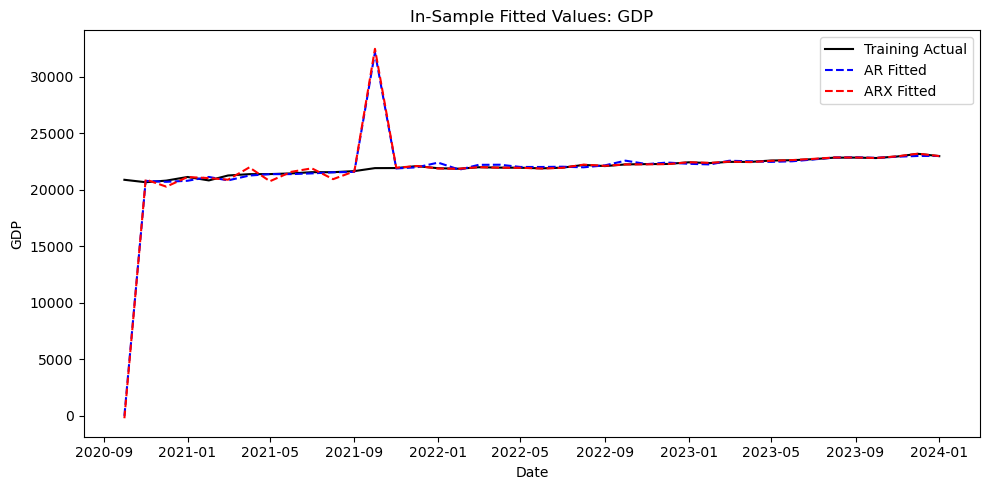

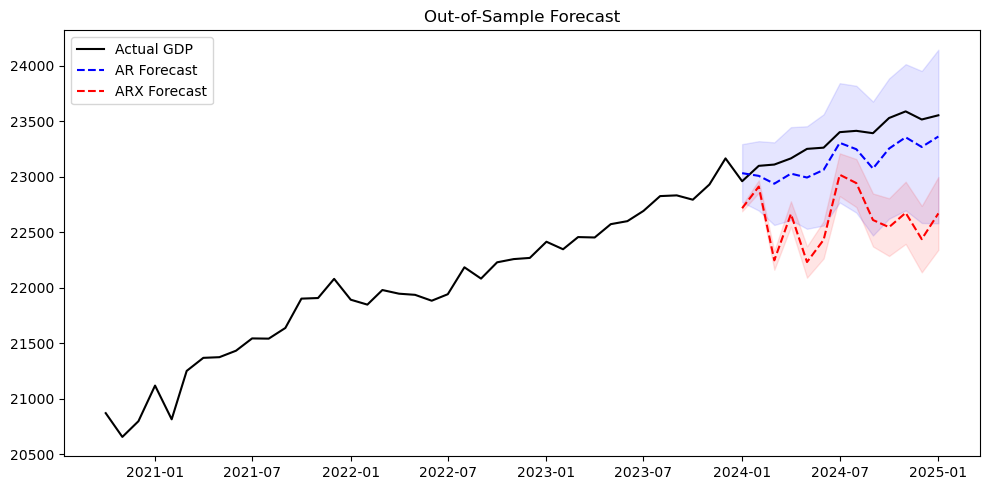

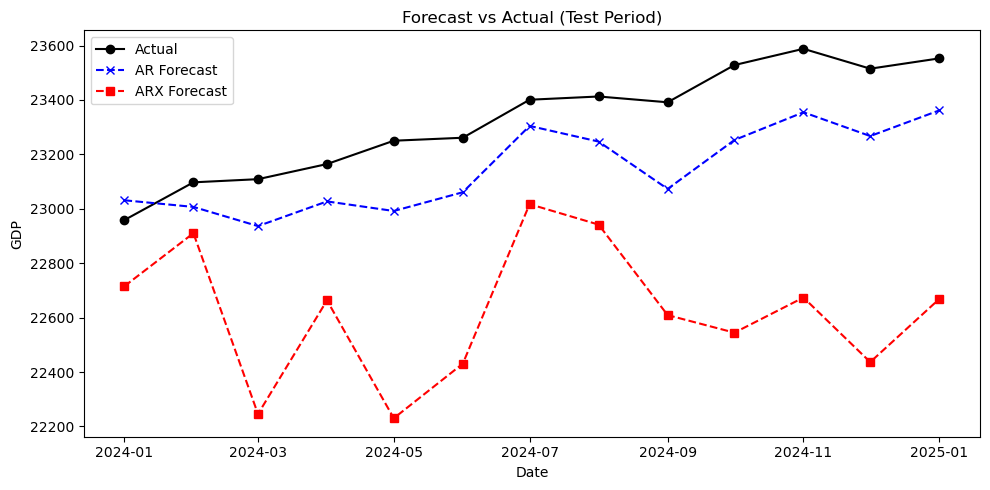

(              MAE        RMSE         R2  MAPE (%)    Order
 Model                                                      
 AR     189.187380  202.902949  -0.104391  0.809554  (1,1,0)
 ARX    703.243776  762.042440 -14.577746  3.008934  (1,1,0),
 {'Breusch-Pagan p': 0.46310474709968075,
  'Shapiro p': 0.2298844726914933,
  'Anderson stat': 0.4129240185874856,
  'Anderson crit': [(15.0, 0.516),
   (10.0, 0.587),
   (5.0, 0.705),
   (2.5, 0.822),
   (1.0, 0.978)],
  'Mean resid': -1.8416919631297508,
  'Durbin-Watson': 1.4331242525704633})

In [109]:
run_model_all_exog(df.copy(), df_exog.copy(), 'GDP', plot = True)

## Checking Variable Stationarity, ACF, PACF

In [ ]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")

In [ ]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=20, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

In [ ]:
# variable = 'PC2_macro'
# check_stationarity(df[variable])
# series = df[variable].dropna()
# acf(series, variable)
# df[f'{variable}_diff'] = df[variable].diff()
# series = df[f'{variable}_diff'].dropna()
# acf(series, f'{variable}_diff')
# check_stationarity(df[f'{variable}_diff'])

# df[f'{variable}_diff_diff'] = df[f'{variable}_diff'].diff()
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

# df[f'{variable}_diff_diff_diff'] = df[f'{variable}_diff_diff'].diff()
# series = df[f'{variable}_diff_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff_diff'])

## SARIMA(X) Model

### P, D, Q Optimization

In [ ]:
# P = Q = range(0, 3)
# D = [0, 1]
# s = 12  
# seasonal_combinations = list(product(P, D, Q))

In [ ]:
# def find_best_seasonal_order(y, macro, ar_orders, exog=None, seasonal_period=12, verbose=False):
#     best_aic = np.inf
#     best_model = None
#     best_seasonal_order = None

#     # Fixed p, d, q
#     order = (
#         ar_orders[macro]['p'],
#         ar_orders[macro]['d'],
#         ar_orders[macro]['q']
#     )

#     for P, D, Q in seasonal_combinations:
#         seasonal_order = (P, D, Q, seasonal_period)

#         try:
#             with warnings.catch_warnings():
#                 warnings.filterwarnings("ignore")
#                 model = SARIMAX(
#                     y,
#                     exog=exog,
#                     order=order,
#                     seasonal_order=seasonal_order,
#                     enforce_stationarity=False,
#                     enforce_invertibility=False
#                 )
#                 results = model.fit(disp=False)

#                 if results.aic < best_aic:
#                     best_aic = results.aic
#                     best_model = results
#                     best_seasonal_order = seasonal_order

#                 if verbose:
#                     print(f"Tried SARIMA{order}x{seasonal_order} AIC={results.aic:.2f}")

#         except Exception as e:
#             if verbose:
#                 print(f"Failed SARIMA{order}x{seasonal_order}: {e}")
#             continue

#     return order, best_seasonal_order, best_model

In [ ]:
# macro = "PC2_macro"
# y = df[macro].dropna()

# order, best_seasonal_order, best_model = find_best_seasonal_order(y, macro, ar_orders, seasonal_period=12, verbose=True)

# print("Fixed order:", order)
# print("Best seasonal order:", best_seasonal_order)
# print("Best AIC:", best_model.aic)

### Running Model

In [47]:
def run_model(df, macro, plot=False):
    outliers = ['2020-03-01', '2020-04-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01']

    order_dict = ar_orders.get(macro, {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0})

    # Unpack ARIMA and seasonal orders
    p = order_dict['p']
    d = order_dict['d']
    q = order_dict['q']
    P = order_dict['P']
    D = order_dict['D']
    Q = order_dict['Q']

    # Extract asset-specific lag
    crypto_lags = {
        k.replace('_lag', ''): v
        for k, v in order_dict.items()
        if k.endswith('_lag') and v is not None
    }

    ### ==== AR Data: Use only macro series ==== ###
    df_macro = df[[macro]].dropna().copy()
    df_macro = df_macro[~df_macro.index.isin(pd.to_datetime(outliers))]
    target_ar = df_macro[macro]
    train_endog_ar = target_ar[train_start:train_end]
    test_endog_ar = target_ar[train_end:]

    ### ==== ARX Data: Use macro + asset ==== ###
    #df_temp = df[[macro, asset]].dropna().copy()
    df_temp = df[[macro] + list(crypto_lags.keys())].dropna().copy()
    df_temp = df_temp[~df_temp.index.isin(pd.to_datetime(outliers))]

    # Create lagged asset columns
    for asset, lag in crypto_lags.items():
        if lag > 0:
            df_temp[f'{asset}_lag{lag}'] = df_temp[asset].shift(lag)
            df_temp.drop(columns=[asset], inplace=True)  # optional: drop original
        else:
            df_temp.rename(columns={asset: f'{asset}_lag0'}, inplace=True)

    df_temp = df_temp.dropna()
    target_arx = df_temp[macro]
    exog_cols = [f'{asset}_lag{lag}' for asset, lag in crypto_lags.items()]
    exog = df_temp[exog_cols]
    
    train_endog_arx = target_arx[train_start:train_end]
    train_exog = exog[train_start:train_end]
    
    test_endog_arx = target_arx[train_end:]
    test_exog = exog[train_end:]

    ### ==== Fit AR and ARX Models ==== ###
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        ar_model = SARIMAX(train_endog_ar, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        ar_result = ar_model.fit(disp=False)
        arx_model = SARIMAX(train_endog_arx, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        arx_result = arx_model.fit(disp=False)
        print(arx_result.summary())

        for warning in w:
            if issubclass(warning.category, ConvergenceWarning):
                print(f"[WARNING] Convergence issue in macro: {macro}")

    ### ==== Forecasts ==== ###
    pred_ar = ar_result.get_forecast(steps=len(test_endog_ar)).predicted_mean
    conf_int_ar = ar_result.get_forecast(steps=len(test_endog_ar)).conf_int()

    pred_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).predicted_mean
    conf_int_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).conf_int()

    # Align index for plotting
    pred_ar.index = test_endog_ar.index
    pred_arx.index = test_endog_arx.index
    conf_int_ar.index = test_endog_ar.index
    conf_int_arx.index = test_endog_arx.index

    # Filtered residuals
    arx_residuals = arx_result.resid[14:]

    ### ==== Plotting ==== ###
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_endog_ar, label='Training Actual', color='black')
        plt.plot(ar_result.fittedvalues, label='AR Fitted', linestyle='--', color='blue')
        plt.plot(arx_result.fittedvalues, label='ARX Fitted', linestyle='--', color='red')
        plt.title(f"In-Sample Fitted Values: {macro}")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(target_ar[train_start:], label='Actual ' + macro, color='black')
        plt.plot(pred_ar, label=f'Forecasted {macro} (AR only)', linestyle='--', color='blue')
        plt.fill_between(pred_ar.index, conf_int_ar.iloc[:, 0], conf_int_ar.iloc[:, 1], color='blue', alpha=0.1)
        plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with crypto)', linestyle='--', color='red')
        plt.fill_between(pred_arx.index, conf_int_arx.iloc[:, 0], conf_int_arx.iloc[:, 1], color='red', alpha=0.1)
        plt.title("Out-of-Sample Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(test_endog_ar, label='Actual ' + macro, marker='o', color='black')
        plt.plot(pred_ar, label=f'AR Forecast', linestyle='--', marker='x', color='blue')
        plt.plot(pred_arx, label=f'ARX Forecast', linestyle='--', marker='s', color='red')
        plt.title("Forecast vs Actual (Test Period)")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # resid_df = arx_residuals.to_frame(name='Residual')
        # resid_df.index.name = 'Month'
        # # Histogram for trimmed residuals
        # plt.figure(figsize=(8, 4))
        # sns.histplot(arx_residuals, kde=True, bins=30, color='skyblue')
        # plt.title("ARX Trimmed Residuals Histogram with KDE")
        # plt.xlabel("Residual")
        # plt.ylabel("Frequency")
        # plt.tight_layout()
        # plt.show()

        # # Print only trimmed residuals
        # print(resid_df)

    ### ==== Metrics ==== ###
    metrics = [
        {
            'Model': 'AR',
            'MAE': mean_absolute_error(test_endog_ar, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog_ar, pred_ar)),
            'R2': r2_score(test_endog_ar, pred_ar),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_ar, pred_ar) * 100,
            'Order': f'({p},{d},{q})'
        },
        {
            'Model': 'ARX',
            'MAE': mean_absolute_error(test_endog_arx, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog_arx, pred_arx)),
            'R2': r2_score(test_endog_arx, pred_arx),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_arx, pred_arx) * 100,
            'Order': f'({p},{d},{q})'
        }
    ]

    assumptions = check_model_assumptions(train_endog_arx[14:], train_exog[14:], arx_residuals)
    return ( pd.DataFrame(metrics).set_index('Model'), assumptions)


                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                   39
Model:             SARIMAX(1, 2, 0)x(1, 1, 0, 12)   Log Likelihood                 -35.183
Date:                            Thu, 03 Jul 2025   AIC                             92.366
Time:                                    09:50:52   BIC                            105.774
Sample:                                11-01-2020   HQIC                            96.085
                                     - 01-01-2024                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Bitcoin_lag0     -0.5520      0.554     -0.997      0.319      -1.637       0.533
Tether_lag1      -0.2442  

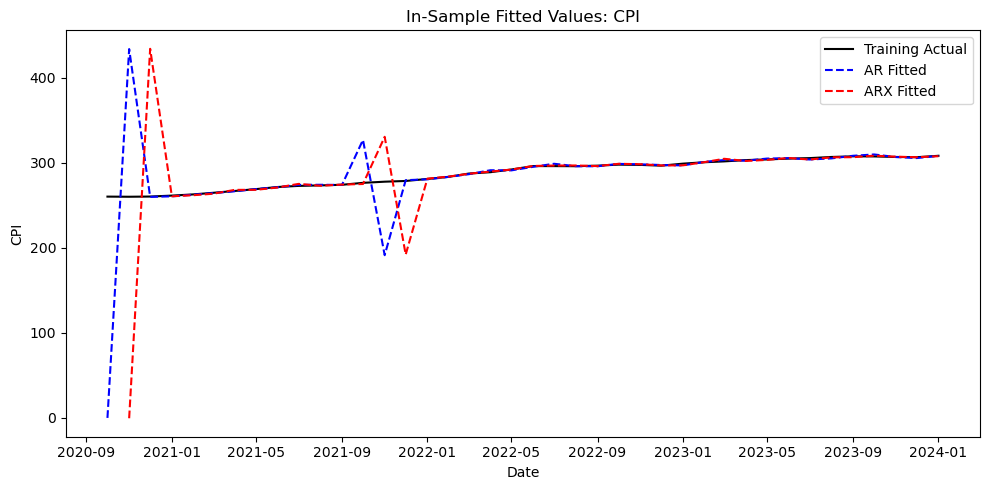

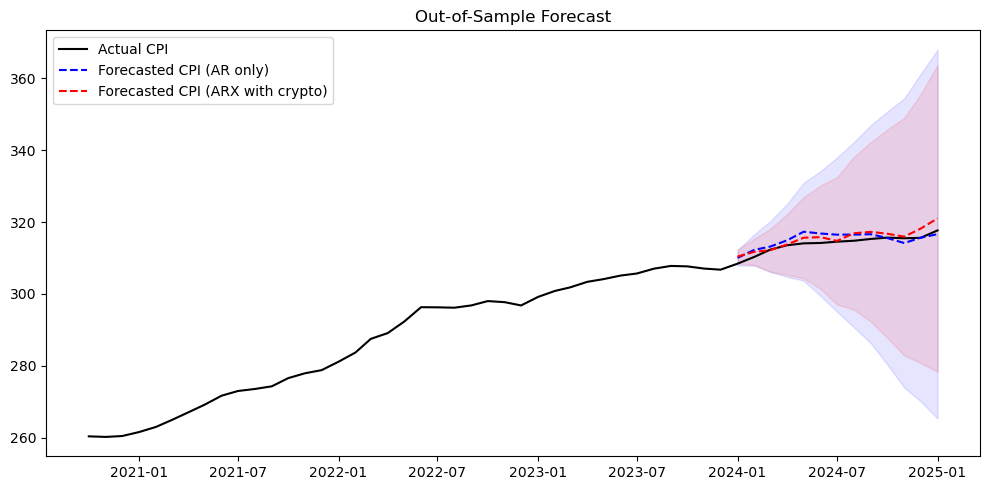

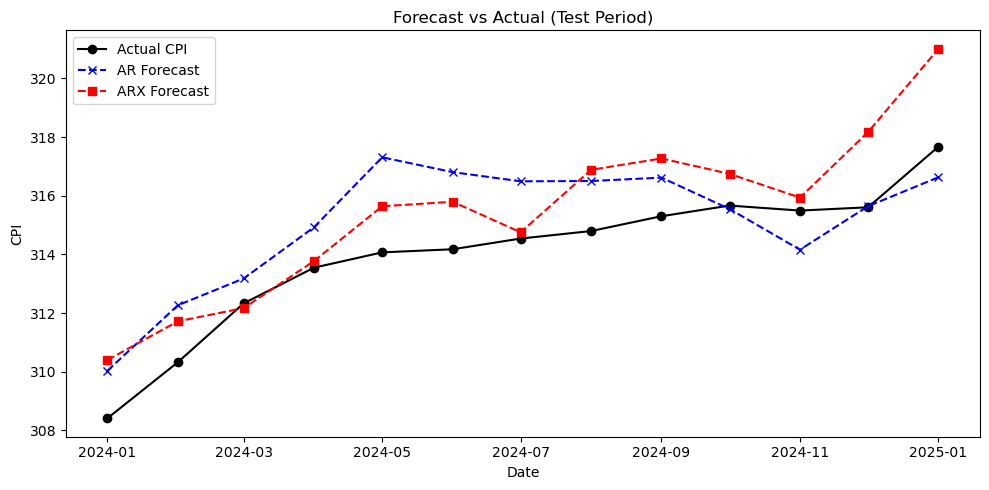

(            MAE      RMSE        R2  MAPE (%)    Order
 Model                                                 
 AR     1.473270  1.703427  0.471373  0.469791  (1,2,0)
 ARX    1.433802  1.717683  0.462488  0.456117  (1,2,0),
 {'Breusch-Pagan p': 0.17641050298332278,
  'Shapiro p': 0.09958456895894988,
  'Anderson stat': 0.5373819225562357,
  'Anderson crit': [(15.0, 0.514),
   (10.0, 0.586),
   (5.0, 0.703),
   (2.5, 0.82),
   (1.0, 0.975)],
  'Mean resid': -0.08721051953835512,
  'Durbin-Watson': 2.2822577864831235})

In [48]:
run_model(df.copy(), 'CPI', plot = True)

## Sliding Window

In [ ]:
# start
initial_start = pd.to_datetime("2020-06-01")
initial_end = pd.to_datetime("2021-05-01")
macro = "CPI" 
window_months = 88

results_list = []
window_num = 1

current_start = initial_start
current_end = initial_end

if current_end <= df.index[-1]:
    # Extract the macro data for this window
    window_data = df.loc[current_start:current_end].dropna(subset=[macro])
    if len(window_data) < 6:
        # Not enough data for this window, skip or exit
        pass

    # 80-20 split by index
    split_idx = int(len(window_data) * 0.8)
    train_dates = window_data.index[:split_idx]
    test_dates = window_data.index[split_idx:]

    # Update train_start and train_end used in run_model()
    globals()['train_start'] = train_dates[0]
    globals()['train_end'] = train_dates[-1]

# Run the model
try:
    metrics_df, _, pred_ar, pred_arx, conf_int_ar, conf_int_arx, test_endog_ar = run_model(df, macro, plot=True)
except (np.linalg.LinAlgError, ValueError) as e:
    print(f"[SKIPPED] Window {window_num}: {e}")
    metrics_df = None  # explicitly set to None

    if len(test_dates) == 0:
        # No test dates left, exit or skip
        pass

    current_start = test_dates[0]
    current_end = current_start + pd.DateOffset(months=window_months - 1)
    window_num += 1
    # continue
    pass

if metrics_df is not None:
    metrics_df['Window'] = f"{current_start.date()} to {current_end.date()}"
    metrics_df['Train'] = f"{train_dates[0].date()} to {train_dates[-1].date()}"
    metrics_df['Test'] = f"{test_dates[0].date()} to {test_dates[-1].date()}"
    metrics_df['Window_Num'] = window_num
    results_list.append(metrics_df)

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(df[macro][train_start:], label='Actual ' + macro, color='black')
    plt.plot(pred_ar, label=f'Forecasted {macro} (AR only)', linestyle='--', color='blue')
    plt.fill_between(pred_ar.index, conf_int_ar.iloc[:, 0], conf_int_ar.iloc[:, 1], color='blue', alpha=0.1)
    plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with crypto)', linestyle='--', color='red')
    plt.fill_between(pred_arx.index, conf_int_arx.iloc[:, 0], conf_int_arx.iloc[:, 1], color='red', alpha=0.1)
    plt.title(f"[Window {window_num}] Out-of-Sample Forecast")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(test_endog_ar, label='Actual ' + macro, marker='o', color='black')
    plt.plot(pred_ar, label=f'AR Forecast', linestyle='--', marker='x', color='blue')
    plt.plot(pred_arx, label=f'ARX Forecast', linestyle='--', marker='s', color='red')
    plt.title(f"[Window {window_num}] Forecast vs Actual (Test Period)")
    plt.xlabel("Date")
    plt.ylabel(macro)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot/metrics due to model error.")

### ========== Prepare Next Window ========== ###
if len(test_dates) == 0:
    pass  # No more test dates, nothing to do
else:
    current_start = test_dates[0]
    current_end = current_start + pd.DateOffset(months=window_months - 1)
    window_num += 1

# Combine all results
if results_list:
    results_df = pd.concat(results_list).set_index(['Window_Num', 'Model'])
else:
    print("No results to concatenate. The results_list is empty.")
    results_df = None



## Assumption Testing Results

In [19]:
all_assumptions = []

for macro in ar_orders.keys():
    try:
        metrics, assumptions = run_model(df, macro, plot=False)
        result_row = {
            "Macro": macro,
            "Asset": asset,
            "Breusch-Pagan p": assumptions["Breusch-Pagan p"],
            "Shapiro p": assumptions["Shapiro p"],
            "Anderson stat": assumptions["Anderson stat"],
            "Mean resid": assumptions["Mean resid"],
        }

        # Optionally flatten Anderson critical values at 5% level
        for level, crit_val in assumptions["Anderson crit"]:
            if level == 5:
                result_row["Anderson 5% crit"] = crit_val

        all_assumptions.append(result_row)

    except Exception as e:
        print(f"Failed for Macro: {macro}")
assumptions_df = pd.DataFrame(all_assumptions)


Failed for Macro: LFPR
Failed for Macro: CPI
Failed for Macro: r
[WARNING] Convergence issue in macro: M1
Failed for Macro: M1
[WARNING] Convergence issue in macro: GDP
[WARNING] Convergence issue in macro: GDP
Failed for Macro: GDP
Failed for Macro: IM
Failed for Macro: EX
Failed for Macro: CC


In [ ]:
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # (optional) Show all columns
pd.set_option("display.width", None)  # Don't wrap columns
pd.set_option("display.max_colwidth", None)  # Don't truncate cell content
display(assumptions_df) 

## Finding Optimal Crypto Lag

In [ ]:
def filter_relevant_assets(df, macro, crypto_assets, threshold=0.2):
    corr = df[[macro] + crypto_assets].corr()[macro].abs()
    return [asset for asset in crypto_assets if corr[asset] > threshold]

In [20]:
def run_model_lag(df, macro, crypto_lags, plot=False):
    outliers = ['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
                '2020-07-01', '2020-08-01', '2020-09-01']

    # Get ARIMA orders
    order_dict = ar_orders.get(macro, {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0})
    p, d, q = order_dict['p'], order_dict['d'], order_dict['q']
    P, D, Q = order_dict['P'], order_dict['D'], order_dict['Q']

    ### ==== AR Data: Use only macro series ==== ###
    df_macro = df[[macro]].dropna().copy()
    df_macro = df_macro[~df_macro.index.isin(pd.to_datetime(outliers))]
    target_ar = df_macro[macro]
    train_endog_ar = target_ar[train_start:train_end]
    test_endog_ar = target_ar[train_end:]

    ### ==== ARX Data: Use macro + crypto assets ==== ###
    df_temp = df[[macro] + list(crypto_lags.keys())].dropna().copy()
    df_temp = df_temp[~df_temp.index.isin(pd.to_datetime(outliers))]

    # Create lagged columns
    for asset, lag in crypto_lags.items():
        if lag > 0:
            df_temp[f'{asset}_lag{lag}'] = df_temp[asset].shift(lag)
            df_temp.drop(columns=[asset], inplace=True)
        else:
            df_temp.rename(columns={asset: f'{asset}_lag0'}, inplace=True)

    df_temp = df_temp.dropna()
    target_arx = df_temp[macro]
    exog_cols = [f'{asset}_lag{lag}' for asset, lag in crypto_lags.items()]
    exog = df_temp[exog_cols]

    train_endog_arx = target_arx[train_start:train_end]
    train_exog = exog[train_start:train_end]
    test_endog_arx = target_arx[train_end:]
    test_exog = exog[train_end:]

    ### ==== Fit AR and ARX Models ==== ###
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        ar_model = SARIMAX(train_endog_ar, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        ar_result = ar_model.fit(disp=False)
        arx_model = SARIMAX(train_endog_arx, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        arx_result = arx_model.fit(disp=False)

        for warning in w:
            if issubclass(warning.category, ConvergenceWarning):
                print(f"[WARNING] Convergence issue in macro: {macro}")

    ### ==== Forecasts ==== ###
    pred_ar = ar_result.get_forecast(steps=len(test_endog_ar)).predicted_mean
    conf_int_ar = ar_result.get_forecast(steps=len(test_endog_ar)).conf_int()

    pred_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).predicted_mean
    conf_int_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).conf_int()

    # Align indices
    pred_ar.index = test_endog_ar.index
    pred_arx.index = test_endog_arx.index
    conf_int_ar.index = test_endog_ar.index
    conf_int_arx.index = test_endog_arx.index

    # Residuals
    arx_residuals = arx_result.resid[14:]

    ### ==== Plotting ==== ###
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_endog_ar, label='Training Actual', color='black')
        plt.plot(ar_result.fittedvalues, label='AR Fitted', linestyle='--', color='blue')
        plt.plot(arx_result.fittedvalues, label='ARX Fitted', linestyle='--', color='red')
        plt.title(f"In-Sample Fitted Values: {macro}")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(target_ar[train_start:], label='Actual ' + macro, color='black')
        plt.plot(pred_ar, label='AR Forecast', linestyle='--', color='blue')
        plt.fill_between(pred_ar.index, conf_int_ar.iloc[:, 0], conf_int_ar.iloc[:, 1], color='blue', alpha=0.1)
        plt.plot(pred_arx, label='ARX Forecast', linestyle='--', color='red')
        plt.fill_between(pred_arx.index, conf_int_arx.iloc[:, 0], conf_int_arx.iloc[:, 1], color='red', alpha=0.1)
        plt.title("Out-of-Sample Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(test_endog_ar, label='Actual', marker='o', color='black')
        plt.plot(pred_ar, label='AR Forecast', linestyle='--', marker='x', color='blue')
        plt.plot(pred_arx, label='ARX Forecast', linestyle='--', marker='s', color='red')
        plt.title("Forecast vs Actual (Test Period)")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

    ### ==== Metrics ==== ###
    metrics = [
        {
            'Model': 'AR',
            'MAE': mean_absolute_error(test_endog_ar, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog_ar, pred_ar)),
            'R2': r2_score(test_endog_ar, pred_ar),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_ar, pred_ar) * 100,
            'Order': f'({p},{d},{q})'
        },
        {
            'Model': 'ARX',
            'MAE': mean_absolute_error(test_endog_arx, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog_arx, pred_arx)),
            'R2': r2_score(test_endog_arx, pred_arx),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_arx, pred_arx) * 100,
            'Order': f'({p},{d},{q})'
        }
    ]

    assumptions = check_model_assumptions(train_endog_arx[14:], train_exog[14:], arx_residuals)
    return pd.DataFrame(metrics).set_index('Model'), assumptions


In [ ]:
def evaluate_combo(df, macro, crypto_lags):
    try:
        metrics_df, _ = run_model_lag(df, macro, crypto_lags, plot=False)
        ar_mape = metrics_df.loc['AR', 'MAPE (%)']
        arx_mape = metrics_df.loc['ARX', 'MAPE (%)']
        improvement = ar_mape - arx_mape
        return (crypto_lags, improvement)
    except Exception as e:
        return (None, float('-inf'))

def find_optimal_lags_for_macro_parallel(df, macro, crypto_assets, max_lag=3, n_jobs=-1):
    from itertools import product
    all_lag_combos = list(product(range(max_lag + 1), repeat=len(crypto_assets)))
    print(f"Searching {len(all_lag_combos)} combinations for {macro}...")

    lag_dicts = [dict(zip(crypto_assets, combo)) for combo in all_lag_combos]
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_combo)(df, macro, lags) for lags in tqdm(lag_dicts, desc=f"Optimizing {macro}")
    )

    best_combo, best_score = max(results, key=lambda x: x[1])
    print(f"Best lag combo: {best_combo} with MAPE improvement {best_score:.2f}")
    return best_combo

In [ ]:
macro = 'CPI'
crypto_assets = asset_list
filtered_assets = filter_relevant_assets(df, macro, crypto_assets, threshold = 0.2)
print(filtered_assets)

In [ ]:
best_lags = find_optimal_lags_for_macro_parallel(df, macro, crypto_assets, max_lag=1)

In [ ]:
fixed_assets = {asset: lag for asset, lag in best_lags.items() if lag == 0}
to_optimize_assets = [asset for asset, lag in best_lags.items() if lag > 0]

print("Fixed lags:", fixed_assets)
print("Assets to optimize further:", to_optimize_assets)

In [ ]:
if to_optimize_assets:
    refined_lags = find_optimal_lags_for_macro_parallel(df, macro, to_optimize_assets, max_lag=3)

    # Combine final lags
    final_lags = {**fixed_assets, **refined_lags}
else:
    final_lags = fixed_assets

print("Final best lags:", final_lags)